<a href="https://colab.research.google.com/github/NegarMov/Brain-Tumor-Classification/blob/main/Brain_Tumor_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import the required packages

In [ ]:
import kagglehub
import shutil
import os
import random
import math
from tqdm import tqdm
import numpy as np
import seaborn as sn
from PIL import Image

import matplotlib as mpl
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
import torch.nn.functional as F

from torchvision import transforms
import torchvision.models as models

from sklearn.utils import class_weight
from sklearn.model_selection import train_test_split, KFold

# Define constants

In [ ]:
# human-readable class names
class_names = ['Glioma Tumor', 'Meningioma Tumor', 'No Tumor', 'Pituitary Tumor']

# folder name for each class
class_folders = ['glioma', 'meningioma', 'notumor', 'pituitary']

# model constants
image_size = 224
batch_size = 32
learning_rate = 5 * 1e-4
num_epochs = 10
k_folds = 10

# Set the Random Seed

In [ ]:
SEED = 0

torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

# Download the dataset from Kaggle

In [ ]:
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

shutil.copytree(path, '/content/dataset')

100%|██████████| 149M/149M [00:07<00:00, 20.4MB/s]

Extracting files...


'/content/dataset'

# Load the dataset

In [ ]:
def load_images_from_folder(root_dir):
  images = []
  labels = []

  for label, class_folder in enumerate(class_folders):
    class_dir = os.path.join(root_dir, class_folder)
    for filename in os.listdir(class_dir):
      img_path = os.path.join(class_dir, filename)
      images.append(img_path)
      labels.append(label)

  return np.array(images), np.array(labels)

In [ ]:
train_images, train_labels = load_images_from_folder('/content/dataset/Training')
test_images, test_labels = load_images_from_folder('/content/dataset/Testing')

In [ ]:
class MRI_Dataset(Dataset):
  def __init__(self, images, labels):
    self.images = images
    self.labels = labels

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    img_path = self.images[idx]
    image = Image.open(img_path).convert('L')
    return {
      "images": image,
      "labels": self.labels[idx]
    }

The wrapper dataset enables applying different transform functions to train and validation sets, as one needs augmentation and one does not (this workaround is needed as k-fold cross-validation is used).

In [ ]:
class WrapperDataset:
  def __init__(self, dataset, dataset_type):
    self.dataset = dataset

    base_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    aug_transform = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(degrees=5),
        transforms.ToTensor(),
        transforms.Lambda(lambda x: x.repeat(3, 1, 1)),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    self.transform = aug_transform if dataset_type == 'train' else base_transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, index):
    image = self.dataset[index]["images"]
    label = self.dataset[index]["labels"]

    return {
      "images": self.transform(image),
      "labels": label
    }

In [ ]:
train_dataset = MRI_Dataset(train_images, train_labels)
test_dataset = WrapperDataset(MRI_Dataset(test_images, test_labels), 'test')

kfold = KFold(n_splits=k_folds, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

len(train_dataset), len(test_dataset)

(5712, 1311)

Class weights would be later used in the loss function to mitigate class imbalance during training.

In [ ]:
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)

class_weights

array([1.08099924, 1.06646751, 0.89529781, 0.98009609])

# Set up the model

In [ ]:
class NeuralNet(nn.Module):
  def __init__(self):
    super(NeuralNet, self).__init__()

    # CNN layers
    self.cnn = models.shufflenet_v2_x0_5(pretrained=True)
    self.cnn.fc = torch.nn.Sequential(*(list(self.cnn.fc.children())[:-1]))

    for i, child in enumerate(self.cnn.children()):
      for param in child.parameters():
        param.requires_grad = i >= 4

    self.cnn_bn = nn.BatchNorm1d(1024)

    # Dense layers
    self.dense = nn.Sequential(
      nn.Dropout(0.3),
      nn.Linear(1024, 100),
      nn.ReLU(),
      nn.Dropout(0.3),
      nn.Linear(100, 4)
    )


  def forward(self, input):
    # CNN layers
    cnn_out = self.cnn(input)
    cnn_out = self.cnn_bn(cnn_out)

    # FC layers
    out = self.dense(cnn_out)

    return out

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

device

device(type='cuda')

In [ ]:
def initiate_model():
  model = NeuralNet()
  model.to(device)

  tensor_class_weights = torch.tensor(class_weights).float().to(device)

  criterion = nn.CrossEntropyLoss(
      weight=tensor_class_weights,
      reduction='mean'
  )

  optimizer = torch.optim.Adam(
      model.parameters(),
      lr=learning_rate,
      weight_decay=1e-3
  )

  scheduler = lr_scheduler.LinearLR(
      optimizer,
      start_factor=1.0,
      end_factor=0.5,
      total_iters=num_epochs//2
  )

  return model, criterion, optimizer, scheduler

# Train the model

In [ ]:
train_loss = []
val_loss = []

train_acc = []
val_acc = []

trained_models = []

torch.autograd.set_detect_anomaly(True)

for fold, (train_ids, val_ids) in enumerate(kfold.split(train_dataset)):

  print(f'\nTraining on fold {fold + 1}')
  print('--------------------------------')

  # prepare the data loaders
  train_loader = torch.utils.data.DataLoader(
    WrapperDataset(train_dataset, 'train'),
    batch_size=batch_size,
    sampler=torch.utils.data.SubsetRandomSampler(train_ids)
  )

  val_loader = torch.utils.data.DataLoader(
    WrapperDataset(train_dataset, 'val'),
    batch_size=batch_size,
    sampler=torch.utils.data.SubsetRandomSampler(val_ids)
  )

  # initiate the model
  model, criterion, optimizer, scheduler = initiate_model()

  # initiate the metrics array
  fold_train_loss = []
  fold_val_loss = []

  fold_train_acc = []
  fold_val_acc = []

  for e in tqdm(range(num_epochs)):

    # training
    model.train()

    avg_loss, total_samples, acc = 0, 0, 0
    for train_data in train_loader:

      img_train = train_data["images"].to(device)
      label_train = train_data["labels"].to(device)

      optimizer.zero_grad()

      label_pred = model(img_train)

      loss = criterion(label_pred, label_train)

      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
      optimizer.step()

      avg_loss += loss.item()
      total_samples += len(img_train)
      acc += torch.sum(torch.argmax(label_pred, axis=-1) == label_train).item()

    fold_train_loss.append(avg_loss / len(train_loader))
    fold_train_acc.append(acc / total_samples)

    # evaluation
    model.eval()
    with torch.no_grad():
      avg_loss, total_samples, acc = 0, 0, 0
      for val_data in val_loader:

        img_val = val_data["images"].to(device)
        label_val = val_data["labels"].to(device)

        label_pred = model(img_val)

        loss = criterion(label_pred, label_val)

        avg_loss += loss.item()
        total_samples += len(img_val)
        acc += torch.sum(torch.argmax(label_pred, axis=-1) == label_val).item()

      fold_val_loss.append(avg_loss / len(val_loader))
      fold_val_acc.append(acc / total_samples)

    print(f"\nLR: {scheduler.get_last_lr()} - Train Accuracy: {fold_train_acc[-1]} - Validation Accuracy: {fold_val_acc[-1]}")

    scheduler.step()

  train_loss.append(fold_train_loss)
  val_loss.append(fold_val_loss)

  train_acc.append(fold_train_acc)
  val_acc.append(fold_val_acc)

  trained_models.append(model)



Training on fold 1
--------------------------------


 10%|█         | 1/10 [00:33<04:58, 33.14s/it]


LR: [0.0005] - Train Accuracy: 0.8653696498054475 - Validation Accuracy: 0.9370629370629371


 20%|██        | 2/10 [01:06<04:28, 33.56s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9342412451361868 - Validation Accuracy: 0.9685314685314685


 30%|███       | 3/10 [01:41<03:56, 33.76s/it]


LR: [0.0004] - Train Accuracy: 0.9573929961089495 - Validation Accuracy: 0.9755244755244755


 40%|████      | 4/10 [02:14<03:21, 33.66s/it]


LR: [0.00035] - Train Accuracy: 0.9673151750972763 - Validation Accuracy: 0.986013986013986


 50%|█████     | 5/10 [02:49<02:51, 34.24s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9772373540856031 - Validation Accuracy: 0.9807692307692307


 60%|██████    | 6/10 [03:23<02:16, 34.19s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9749027237354085 - Validation Accuracy: 0.9895104895104895


 70%|███████   | 7/10 [03:57<01:41, 33.86s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9842412451361867 - Validation Accuracy: 0.9895104895104895


 80%|████████  | 8/10 [04:30<01:07, 33.87s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9828793774319066 - Validation Accuracy: 0.9912587412587412


 90%|█████████ | 9/10 [05:04<00:33, 33.71s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9873540856031129 - Validation Accuracy: 0.993006993006993


100%|██████████| 10/10 [05:37<00:00, 33.78s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9873540856031129 - Validation Accuracy: 0.986013986013986

Training on fold 2
--------------------------------


 10%|█         | 1/10 [00:33<05:04, 33.80s/it]


LR: [0.0005] - Train Accuracy: 0.8583657587548638 - Validation Accuracy: 0.9248251748251748


 20%|██        | 2/10 [01:07<04:27, 33.45s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.93715953307393 - Validation Accuracy: 0.9597902097902098


 30%|███       | 3/10 [01:40<03:54, 33.51s/it]


LR: [0.0004] - Train Accuracy: 0.954863813229572 - Validation Accuracy: 0.9667832167832168


 40%|████      | 4/10 [02:15<03:23, 33.96s/it]


LR: [0.00035] - Train Accuracy: 0.9700389105058366 - Validation Accuracy: 0.9685314685314685


 50%|█████     | 5/10 [02:48<02:47, 33.54s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9770428015564202 - Validation Accuracy: 0.9737762237762237


 60%|██████    | 6/10 [03:21<02:14, 33.51s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9813229571984435 - Validation Accuracy: 0.9755244755244755


 70%|███████   | 7/10 [03:55<01:40, 33.52s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9854085603112841 - Validation Accuracy: 0.972027972027972


 80%|████████  | 8/10 [04:27<01:06, 33.27s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9846303501945526 - Validation Accuracy: 0.9755244755244755


 90%|█████████ | 9/10 [05:01<00:33, 33.40s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9852140077821012 - Validation Accuracy: 0.9737762237762237


100%|██████████| 10/10 [05:35<00:00, 33.52s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9883268482490273 - Validation Accuracy: 0.9685314685314685

Training on fold 3
--------------------------------


 10%|█         | 1/10 [00:32<04:52, 32.52s/it]


LR: [0.0005] - Train Accuracy: 0.8620890877261234 - Validation Accuracy: 0.9369527145359019


 20%|██        | 2/10 [01:06<04:26, 33.27s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9352266096090255 - Validation Accuracy: 0.9614711033274956


 30%|███       | 3/10 [01:40<03:54, 33.52s/it]


LR: [0.0004] - Train Accuracy: 0.9531219607080335 - Validation Accuracy: 0.9737302977232924


 40%|████      | 4/10 [02:13<03:20, 33.48s/it]


LR: [0.00035] - Train Accuracy: 0.9632367243726901 - Validation Accuracy: 0.9842381786339754


 50%|█████     | 5/10 [02:47<02:47, 33.49s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9747130908383583 - Validation Accuracy: 0.9842381786339754


 60%|██████    | 6/10 [03:19<02:12, 33.14s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9770472670686637 - Validation Accuracy: 0.9877408056042032


 70%|███████   | 7/10 [03:53<01:40, 33.37s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9856059132464501 - Validation Accuracy: 0.9912434325744308


 80%|████████  | 8/10 [04:27<01:07, 33.51s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9824936782727096 - Validation Accuracy: 0.9859894921190894


 90%|█████████ | 9/10 [04:59<00:33, 33.24s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9863839719898853 - Validation Accuracy: 0.9912434325744308


100%|██████████| 10/10 [05:33<00:00, 33.32s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9877455747908968 - Validation Accuracy: 0.989492119089317

Training on fold 4
--------------------------------


 10%|█         | 1/10 [00:32<04:52, 32.53s/it]


LR: [0.0005] - Train Accuracy: 0.8652013226998638 - Validation Accuracy: 0.9229422066549913


 20%|██        | 2/10 [01:06<04:28, 33.62s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9395059326979187 - Validation Accuracy: 0.9369527145359019


 30%|███       | 3/10 [01:40<03:54, 33.45s/it]


LR: [0.0004] - Train Accuracy: 0.9564287103676328 - Validation Accuracy: 0.9457092819614711


 40%|████      | 4/10 [02:12<03:18, 33.09s/it]


LR: [0.00035] - Train Accuracy: 0.9675160474615834 - Validation Accuracy: 0.9544658493870403


 50%|█████     | 5/10 [02:45<02:45, 33.12s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9762692083252286 - Validation Accuracy: 0.9649737302977233


 60%|██████    | 6/10 [03:18<02:12, 33.07s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9799649873565455 - Validation Accuracy: 0.9702276707530648


 70%|███████   | 7/10 [03:52<01:40, 33.39s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9856059132464501 - Validation Accuracy: 0.9702276707530648


 80%|████████  | 8/10 [04:28<01:07, 33.99s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9879400894767555 - Validation Accuracy: 0.9737302977232924


 90%|█████████ | 9/10 [05:02<00:34, 34.25s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9854113985605913 - Validation Accuracy: 0.9719789842381786


100%|██████████| 10/10 [05:37<00:00, 33.70s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9863839719898853 - Validation Accuracy: 0.9754816112084063

Training on fold 5
--------------------------------


 10%|█         | 1/10 [00:35<05:17, 35.32s/it]


LR: [0.0005] - Train Accuracy: 0.8652013226998638 - Validation Accuracy: 0.9369527145359019


 20%|██        | 2/10 [01:09<04:38, 34.75s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.936588212410037 - Validation Accuracy: 0.9544658493870403


 30%|███       | 3/10 [01:42<03:58, 34.07s/it]


LR: [0.0004] - Train Accuracy: 0.9550671075666213 - Validation Accuracy: 0.9702276707530648


 40%|████      | 4/10 [02:16<03:24, 34.03s/it]


LR: [0.00035] - Train Accuracy: 0.9661544446605719 - Validation Accuracy: 0.9772329246935202


 50%|█████     | 5/10 [02:51<02:50, 34.10s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9745185761524995 - Validation Accuracy: 0.9807355516637478


 60%|██████    | 6/10 [03:24<02:14, 33.69s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9801595020424042 - Validation Accuracy: 0.9859894921190894


 70%|███████   | 7/10 [03:57<01:41, 33.77s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.984827854503015 - Validation Accuracy: 0.9842381786339754


 80%|████████  | 8/10 [04:31<01:07, 33.65s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9824936782727096 - Validation Accuracy: 0.9842381786339754


 90%|█████████ | 9/10 [05:04<00:33, 33.46s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9883291188484731 - Validation Accuracy: 0.9842381786339754


100%|██████████| 10/10 [05:38<00:00, 33.88s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9871620307333203 - Validation Accuracy: 0.9859894921190894

Training on fold 6
--------------------------------


 10%|█         | 1/10 [00:32<04:52, 32.51s/it]


LR: [0.0005] - Train Accuracy: 0.8607274849251119 - Validation Accuracy: 0.9404553415061296


 20%|██        | 2/10 [01:05<04:24, 33.06s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9437852557868119 - Validation Accuracy: 0.9562171628721541


 30%|███       | 3/10 [01:39<03:52, 33.28s/it]


LR: [0.0004] - Train Accuracy: 0.9609025481423847 - Validation Accuracy: 0.968476357267951


 40%|████      | 4/10 [02:12<03:18, 33.01s/it]


LR: [0.00035] - Train Accuracy: 0.9690721649484536 - Validation Accuracy: 0.9719789842381786


 50%|█████     | 5/10 [02:45<02:45, 33.11s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9782143551838164 - Validation Accuracy: 0.968476357267951


 60%|██████    | 6/10 [03:18<02:12, 33.05s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9801595020424042 - Validation Accuracy: 0.9702276707530648


 70%|███████   | 7/10 [03:51<01:39, 33.03s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9817156195292744 - Validation Accuracy: 0.9754816112084063


 80%|████████  | 8/10 [04:24<01:06, 33.15s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9852168838747325 - Validation Accuracy: 0.9719789842381786


 90%|█████████ | 9/10 [04:57<00:33, 33.17s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.989301692277767 - Validation Accuracy: 0.9754816112084063


100%|██████████| 10/10 [05:31<00:00, 33.11s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9883291188484731 - Validation Accuracy: 0.9754816112084063

Training on fold 7
--------------------------------


 10%|█         | 1/10 [00:33<04:58, 33.21s/it]


LR: [0.0005] - Train Accuracy: 0.8615055436685469 - Validation Accuracy: 0.9352014010507881


 20%|██        | 2/10 [01:05<04:22, 32.76s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9393114180120599 - Validation Accuracy: 0.9492119089316988


 30%|███       | 3/10 [01:39<03:53, 33.35s/it]


LR: [0.0004] - Train Accuracy: 0.9562341956817739 - Validation Accuracy: 0.9702276707530648


 40%|████      | 4/10 [02:12<03:17, 32.99s/it]


LR: [0.00035] - Train Accuracy: 0.9677105621474421 - Validation Accuracy: 0.9807355516637478


 50%|█████     | 5/10 [02:45<02:45, 33.14s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9768527523828049 - Validation Accuracy: 0.9754816112084063


 60%|██████    | 6/10 [03:18<02:12, 33.16s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9819101342151333 - Validation Accuracy: 0.9772329246935202


 70%|███████   | 7/10 [03:51<01:38, 32.88s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9822991635868508 - Validation Accuracy: 0.9807355516637478


 80%|████████  | 8/10 [04:25<01:06, 33.36s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9830772223302859 - Validation Accuracy: 0.9842381786339754


 90%|█████████ | 9/10 [04:57<00:33, 33.07s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9891071775919081 - Validation Accuracy: 0.9824868651488616


100%|██████████| 10/10 [05:30<00:00, 33.07s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9875510601050379 - Validation Accuracy: 0.9807355516637478

Training on fold 8
--------------------------------


 10%|█         | 1/10 [00:33<04:58, 33.16s/it]


LR: [0.0005] - Train Accuracy: 0.8624781170978408 - Validation Accuracy: 0.9352014010507881


 20%|██        | 2/10 [01:05<04:20, 32.61s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9395059326979187 - Validation Accuracy: 0.9614711033274956


 30%|███       | 3/10 [01:38<03:49, 32.74s/it]


LR: [0.0004] - Train Accuracy: 0.9550671075666213 - Validation Accuracy: 0.9544658493870403


 40%|████      | 4/10 [02:10<03:15, 32.56s/it]


LR: [0.00035] - Train Accuracy: 0.9684886208908773 - Validation Accuracy: 0.9614711033274956


 50%|█████     | 5/10 [02:43<02:44, 32.87s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.971406341178759 - Validation Accuracy: 0.9702276707530648


 60%|██████    | 6/10 [03:17<02:12, 33.04s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9850223691888738 - Validation Accuracy: 0.9737302977232924


 70%|███████   | 7/10 [03:50<01:39, 33.18s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9832717370161447 - Validation Accuracy: 0.978984238178634


 80%|████████  | 8/10 [04:24<01:06, 33.26s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9856059132464501 - Validation Accuracy: 0.9807355516637478


 90%|█████████ | 9/10 [04:57<00:33, 33.27s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9852168838747325 - Validation Accuracy: 0.9824868651488616


100%|██████████| 10/10 [05:30<00:00, 33.03s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9891071775919081 - Validation Accuracy: 0.9719789842381786

Training on fold 9
--------------------------------


 10%|█         | 1/10 [00:33<04:58, 33.22s/it]


LR: [0.0005] - Train Accuracy: 0.8591713674382416 - Validation Accuracy: 0.9281961471103327


 20%|██        | 2/10 [01:05<04:23, 32.95s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9360046683524607 - Validation Accuracy: 0.957968476357268


 30%|███       | 3/10 [01:39<03:52, 33.15s/it]


LR: [0.0004] - Train Accuracy: 0.9546780781949037 - Validation Accuracy: 0.9667250437828371


 40%|████      | 4/10 [02:12<03:19, 33.20s/it]


LR: [0.00035] - Train Accuracy: 0.9690721649484536 - Validation Accuracy: 0.9632224168126094


 50%|█████     | 5/10 [02:45<02:46, 33.22s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9735460027232056 - Validation Accuracy: 0.968476357267951


 60%|██████    | 6/10 [03:19<02:12, 33.24s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9824936782727096 - Validation Accuracy: 0.9737302977232924


 70%|███████   | 7/10 [03:51<01:39, 33.02s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9824936782727096 - Validation Accuracy: 0.9772329246935202


 80%|████████  | 8/10 [04:24<01:06, 33.02s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9863839719898853 - Validation Accuracy: 0.9772329246935202


 90%|█████████ | 9/10 [04:58<00:33, 33.16s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9861894573040264 - Validation Accuracy: 0.9737302977232924


100%|██████████| 10/10 [05:30<00:00, 33.04s/it]



LR: [0.00025000000000000006] - Train Accuracy: 0.9858004279323089 - Validation Accuracy: 0.9737302977232924

Training on fold 10
--------------------------------


 10%|█         | 1/10 [00:33<04:59, 33.24s/it]


LR: [0.0005] - Train Accuracy: 0.8640342345847112 - Validation Accuracy: 0.9316987740805605


 20%|██        | 2/10 [01:05<04:22, 32.77s/it]


LR: [0.00045000000000000004] - Train Accuracy: 0.9342540361797316 - Validation Accuracy: 0.9387040280210157


 30%|███       | 3/10 [01:38<03:50, 32.87s/it]


LR: [0.0004] - Train Accuracy: 0.95526162225248 - Validation Accuracy: 0.9667250437828371


 40%|████      | 4/10 [02:12<03:20, 33.43s/it]


LR: [0.00035] - Train Accuracy: 0.9663489593464306 - Validation Accuracy: 0.9632224168126094


 50%|█████     | 5/10 [02:45<02:45, 33.05s/it]


LR: [0.00030000000000000003] - Train Accuracy: 0.9721843999221941 - Validation Accuracy: 0.9649737302977233


 60%|██████    | 6/10 [03:18<02:12, 33.09s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9778253258120988 - Validation Accuracy: 0.9807355516637478


 70%|███████   | 7/10 [03:50<01:38, 32.80s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9822991635868508 - Validation Accuracy: 0.9842381786339754


 80%|████████  | 8/10 [04:23<01:05, 32.93s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9854113985605913 - Validation Accuracy: 0.9842381786339754


 90%|█████████ | 9/10 [04:57<00:33, 33.06s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9896907216494846 - Validation Accuracy: 0.9824868651488616


100%|██████████| 10/10 [05:29<00:00, 32.95s/it]


LR: [0.00025000000000000006] - Train Accuracy: 0.9896907216494846 - Validation Accuracy: 0.9754816112084063


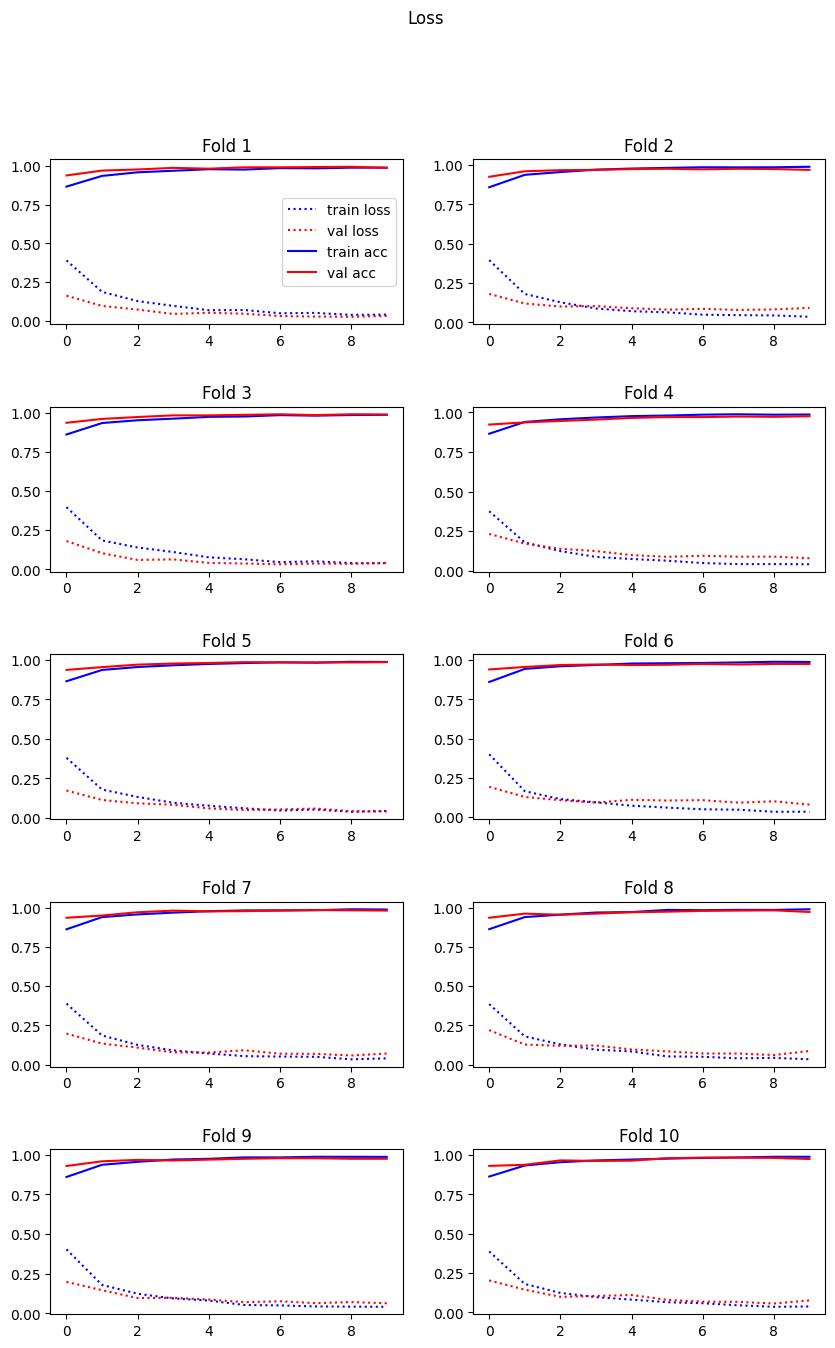

In [ ]:
fig = plt.figure(figsize=(10, 15))
spec = mpl.gridspec.GridSpec(ncols=2, nrows=math.ceil(k_folds / 2.0))

fig.suptitle('Loss')

axes = []
for i in range(spec.nrows):
  for j in range(2):
    axes.append(fig.add_subplot(spec[i, j]))

for i in range(k_folds):
  axes[i].set_title(f'Fold {i + 1}')
  axes[i].plot(train_loss[i], c='b', label='train loss', linestyle='dotted')
  axes[i].plot(val_loss[i], c='r', label='val loss', linestyle='dotted')
  axes[i].plot(train_acc[i], c='b', label='train acc')
  axes[i].plot(val_acc[i], c='r', label='val acc')
  if i == 0:
    axes[i].legend()

plt.subplots_adjust(hspace=0.5)
plt.show()

In [ ]:
print(f'Average accuracy on train dataset: {round(np.mean(np.array(train_acc)[:, -1]) * 100, 2)}')

print(f'Average accuracy on validation dataset: {round(np.mean(np.array(val_acc)[:, -1]) * 100, 2)}')

Average accuracy on train dataset: 98.77
Average accuracy on validation dataset: 97.83


# Evaluate the model on test dataset


The best model among the *k* trained models is selected based on its performance on the validation dataset (minimum loss).

In [ ]:
best_model = trained_models[np.argmin(np.array(val_loss)[:, -1])]

Accuracy on test dataset: 98.93


<Axes: >

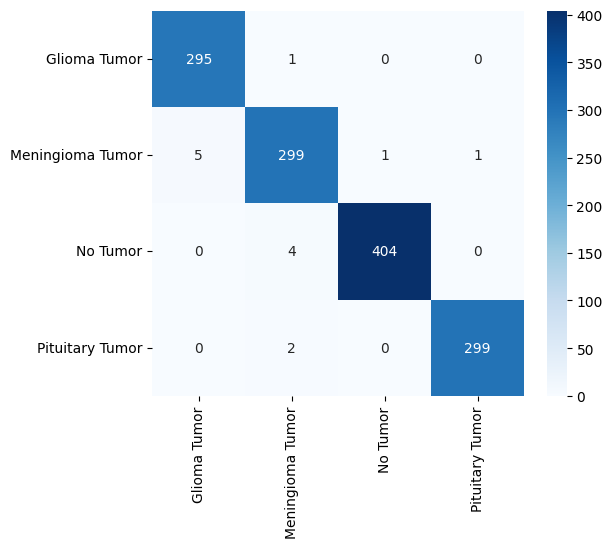

In [ ]:
conf_mat = [[0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0]]

with torch.no_grad():
  best_model.eval()

  avg_loss, total_samples, acc = 0, 0, 0

  for test_data in test_loader:

    img_test = test_data["images"].to(device)
    label_test = test_data["labels"].to(device)

    label_pred = best_model(img_test)

    total_samples += len(img_test)
    acc += torch.sum(torch.argmax(label_pred, axis=-1) == label_test).item()

    for i in range(label_pred.shape[0]):
      if not torch.argmax(label_pred[i]).eq(label_test[i]):
        conf_mat[int(torch.argmax(label_pred[i]).item())][int(label_test[i].item())] += 1
      else:
        conf_mat[int(label_test[i].item())][int(label_test[i].item())] += 1

print(f'Accuracy on test dataset: {round((acc / total_samples) * 100, 2)}')

plt.figure(figsize=(6, 5))
sn.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)